# Striped Skunk Historic Occurrence Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### Set Variables - fill out stuff in this cell.  
Notes:
default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

In [1]:
species_id = 'mstskx0'
summary_name = 'striped_old'
gbif_req_id = 'Gr26'
gbif_filter_id = 'Gf10'
default_coordUncertainty = 1000       # Note above.
workDir = 'P:/Proj3/USGap/Vert/USranges/2020v1/'
codeDir = 'T:/code/wildlife-wrangler/'
paramdb = 'P:/Proj3/USGap/Vert/DBase/wildlife-wrangler.sqlite'
configDir = 'T:/GAP/Data/'  # Path to folder where saved your wildlifeconfig file.

There is a bug with mpl_toolkits, the following code is a temp fix, hopefully.
https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410

In [2]:
import os
os.environ['PROJ_LIB'] = r'c:\Users\nmtarr\AppData\Local\Continuum\miniconda3\envs\wrangler\Library\share'

### Setup - nothing to fill out in this cell

In [3]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import sys
sys.path.append(configDir)
import wranglerconfig as config
sys.path.append(codeDir)
import wrangler_functions as functions
inDir = workDir + 'Inputs/'
outDir = workDir
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'
username = config.gbif_username
password = config.gbif_password
email = config.gbif_email
print("Notebook run " + str(t1))
print(spdb)
connjup = sqlite3.connect(paramdb)
cursorjup = connjup.cursor()
# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

Notebook run 2020-04-27 10:36:01.442808
P:/Proj3/USGap/Vert/USranges/2020v1/mstskx0Gr26Gf10.sqlite


# Species Concept
Display information on the species from the parameters.sqlite database.

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
sp_dict = dict(zip(cols, vals))
sp_df = pd.DataFrame.from_dict(sp_dict, orient='index', columns=['VALUE'])
sp_df.index.name = 'ATTRIBUTE'
print("SPECIES CONCEPT RECORD")
print(sp_df)

SPECIES CONCEPT RECORD
                                                   VALUE
ATTRIBUTE                                               
species_id                                       mstskx0
fws_id                                              None
gap_id                                            mstskx
itis_tsn                                          180562
gbif_id                                          5219380
bcb_id                                              None
ebird_id                                            None
common_name                                striped skunk
scientific_name                        Mephitis mephitis
start_year                                          1776
split_from                                          None
end_year                                            None
lumped_into                                         None
geometry                                            None
detection_distance_meters                             30
vetted_h

# Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [5]:
request_df = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(request_df.loc[0])

THE REQUEST FILTER SET
request_id                               Gr26
source                                   GBIF
lat_range                                None
lon_range                                None
years_range                         2000,2015
months_range                             1,12
geoissue                                False
coordinate                               True
country                                    US
geometry                                 None
creator                               N. Tarr
notes           Built for GAP v2 range map...
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [6]:
filter_df = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(filter_df.loc[0])

THE POST REQUEST FILTER SET
filter_id                                              Gf10
dataset                                                GBIF
institutions_omit                                      None
collection_codes_omit                                  None
datasets_omit                                          None
has_coordinate_uncertainty                                0
max_coordinate_uncertainty                             5000
bases_omit                                  FOSSIL_SPECIMEN
sampling_protocols_omit                                    
issues_omit                   TAXON_MATCH_HIGHERRANK, GE...
duplicates_OK                                         False
creator                                             N. Tarr
notes                         For use in creating GAP ve...
Name: 0, dtype: object


## Filter set justification

**default_coord_uncertainty:** Set to 1000m to be a little cautious.  May overide values before applying to range update, assessing based on age and source.

**years_range:** The range update objective is to represent "historic" data.  Start year picked based on roughly when modern GPS became accessible.  End year chosen not to overlap with the query for recent records (GBIFr25).

**months_range:** There is no reason to limit on month for this species.

**geoissue:** Due to the spatial aspects of the intended application, persistent geoissues would be problematic.

**coordinate:** Coordinates are required for the spatial nature of the intended applications (range map updates).

**country:** GAP ranges only cover the lower 48 states.

**geometry:** No extra geometry filters deployed as there is not basis or reason to do so.

**collection_codes_omit:** No basis or reason to omit based on collection.  Weighting records may be adjusted based on collection later though.

**institutions_omit:** No basis or reason to omit based on collection.  Weighting records may be adjusted based on collection later though.

**datasets_omit:** No basis or reason to omit based on collection.  Weighting records may be adjusted based on collection later though.

**has_coordinate_uncertainty:** Lack of coordinate uncertainty will/can be handled with default values for this application.

**max_coordinate_uncertainty:** Records with large coordinate uncertainty values effectively get dropped when assessed against the locations of 12 digit hucs and counties.  

**bases_omit:** Fossils are not appropriate for GAP range maps.

**sampling_protocols_omit:** No basis or reason to omit based on collection.  Weighting records may be adjusted based on collection later though.

**issues_omit:** 'TAXON_MATCH_HIGHERRANK' -- Records must match species concept of the GAP data; 'RECORDED_DATE_MISMATCH' -- OK to use since temporal extent is so long; 'GEODETIC_DATUM_INVALID' -- Omit because could cause wrong huc to be selected; 'COORDINATE_UNCERTAINTY_METERS_INVALID' -- Kept because value can be overriden later; 'TYPE_STATUS_INVALID' -- Not sure what that means but sounds bad.

**duplicates:** The quality of duplicates on date and x,y location is questionable, so erring on the side of caution.

In [7]:
functions.retrieve_gbif_occurrences(codeDir, species_id, paramdb, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, outDir, summary_name, username,
                                   password, email)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:01.138272
Got request params and sorted out geometry constraints: 0:00:00.002073
1141 records available
Downloaded records: 0:00:07.863450
Summarized fields returned: 0:00:31.116977
Created summary table of request results: 0:00:00.138850
Performed post-request filtering: 0:00:00.010219
Calculated new columns, deleted some too: 0:00:00.012260
33 duplicate records dropped: 0:00:00.488105
Inserted records into table: 0:00:00.257622
Summarized unique values retained: 0:00:00.003983
Updated occurrences table geometry column: 0:00:00.481121
Buffered points: 0:00:02.693562
Exported shapefile: 0:00:01.871879

Records saved in P:/Proj3/USGap/Vert/USranges/2020v1/mstskx0Gr26Gf10.sqlite


### Connect to output database, record species and filter info.

In [8]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
sp_df.to_sql(name='species_concept', con=conn_occ, if_exists='replace')
request_df.to_sql(name=gbif_req_id, con=conn_occ, if_exists='replace')
filter_df.to_sql(name=gbif_filter_id, con=conn_occ, if_exists='replace')

### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [9]:
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

1022 records


# Sources
#### Pre-filters

In [10]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sources = pd.read_sql(sql="SELECT * FROM pre_filter_source_counts;", con=conn_occ)
print(sources)

GBIF
   institutionCode    collectionCode                    datasetName    0
0            ASNHC           Mammals                        UNKNOWN  418
1              CAS               MAM                        UNKNOWN    1
2             DMNS  Mammal specimens                        UNKNOWN    1
3             FHSM            FHSM-M  Fort Hays Sternberg Museum...    2
4             FMNH           Mammals                        UNKNOWN   10
5              MSB  Mammal specimens                        UNKNOWN   25
6              MVZ  Mammal specimens                        UNKNOWN   15
7             OMNH           Mammals                        UNKNOWN    5
8             OMNH              OCGR  Oklahoma Collection of Gen...    4
9             TCWC           Mammals                        UNKNOWN    1
10             UAZ           Mammals                        UNKNOWN    1
11           UCONN           Mammals                        UNKNOWN    4
12              UF                UF          

#### Post-filters

In [11]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sql = "SELECT institutionCode, collectionCode, datasetName, COUNT(occ_id) FROM occurrences GROUP BY institutionCode, collectionCode, datasetName;"
sources = pd.read_sql(sql=sql, con=conn_occ)
print(sources)

GBIF
   institutionCode    collectionCode                    datasetName  COUNT(occ_id)
0            ASNHC           Mammals                        UNKNOWN            396
1              CAS               MAM                        UNKNOWN              1
2             DMNS  Mammal specimens                        UNKNOWN              1
3             FHSM            FHSM-M  Fort Hays Sternberg Museum...              2
4             FMNH           Mammals                        UNKNOWN              8
5              MSB  Mammal specimens                        UNKNOWN              9
6              MVZ  Mammal specimens                        UNKNOWN             11
7             OMNH           Mammals                        UNKNOWN              5
8             TCWC           Mammals                        UNKNOWN              1
9              UAZ           Mammals                        UNKNOWN              1
10           UCONN           Mammals                        UNKNOWN              4

# Bases
#### Pre-filter

In [12]:
bases = pd.read_sql(sql="SELECT value as basisOfRecord, count FROM pre_filter_value_counts WHERE attribute = 'bases';", con=conn_occ)
print(bases)

        basisOfRecord  count
0     FOSSIL_SPECIMEN      1
1   HUMAN_OBSERVATION    640
2  PRESERVED_SPECIMEN    500


#### Post-filters

In [13]:
sql = "SELECT basisOfRecord, COUNT(occ_id) as count FROM occurrences GROUP BY basisOfRecord;"
bases = pd.read_sql(sql=sql, con=conn_occ)
print(bases)

        basisOfRecord  count
0   HUMAN_OBSERVATION    573
1  PRESERVED_SPECIMEN    449


# Protocols
#### Pre-filters

In [14]:
protocol = pd.read_sql(sql="SELECT value as samplingProtocol, count FROM pre_filter_value_counts WHERE attribute = 'samplingProtocols';", con=conn_occ)
print(protocol)

  samplingProtocol  count
0        Road kill      1
1          UNKNOWN   1134
2          salvage      6


#### Post-filters

In [15]:
sql = "SELECT samplingProtocol, COUNT(occ_id) as count FROM occurrences GROUP BY samplingProtocol;"
print(pd.read_sql(sql=sql, con=conn_occ))

  samplingProtocol  count
0        Road kill      1
1          UNKNOWN   1020
2          salvage      1


# Issues
#### Pre-filters

In [16]:
iss = pd.read_sql(sql="SELECT value as issues, count FROM pre_filter_value_counts WHERE attribute = 'issues';", con=conn_occ)
pd.set_option('display.max_colwidth', 80)
print(iss)

                                                                             issues  count
0               ['COORDINATE_REPROJECTED', 'COORDINATE_UNCERTAINTY_METERS_INVALID']      1
1                                                        ['COORDINATE_REPROJECTED']      3
2   ['COORDINATE_ROUNDED', 'COORDINATE_REPROJECTED', 'COORDINATE_UNCERTAINTY_MET...      1
3                                  ['COORDINATE_ROUNDED', 'COORDINATE_REPROJECTED']      5
4                            ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84']    330
5   ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_INVALID', 'GEODETIC_DATUM_ASSUMED_WGS...      3
6                                     ['COORDINATE_ROUNDED', 'TYPE_STATUS_INVALID']      1
7                                                            ['COORDINATE_ROUNDED']      9
8                   ['GEODETIC_DATUM_ASSUMED_WGS84', 'PRESUMED_SWAPPED_COORDINATE']      1
9                                                  ['GEODETIC_DATUM_ASSUMED_WGS84']    757

#### Post-filters

In [17]:
sql = "SELECT issues, COUNT(occ_id) as count FROM occurrences GROUP BY issues;"
print(pd.read_sql(sql=sql, con=conn_occ))

                                                                            issues  count
0                                                                                      22
1                                                           COORDINATE_REPROJECTED      3
2                     COORDINATE_REPROJECTED;COORDINATE_UNCERTAINTY_METERS_INVALID      1
3                                                               COORDINATE_ROUNDED      3
4                                        COORDINATE_ROUNDED;COORDINATE_REPROJECTED      3
5  COORDINATE_ROUNDED;COORDINATE_REPROJECTED;COORDINATE_UNCERTAINTY_METERS_INVALID      1
6                                  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84    274
7                                                     GEODETIC_DATUM_ASSUMED_WGS84    714
8                         GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_SWAPPED_COORDINATE      1


# Descriptions of filtered records

### Locations

T:/code/wildlife-wrangler\wrangler_functions.py:41: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  height=3200000, width=5000000)
T:/code/wildlife-wrangler\wrangler_functions.py:43: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawstates(color='grey')
T:/code/wildlife-wrangler\wrangler_functions.py:44: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawcountries(color='grey')
T:/code/wildlife-wrangler\wrangler_functions.py:55: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  color=mapfile['linecolor'])


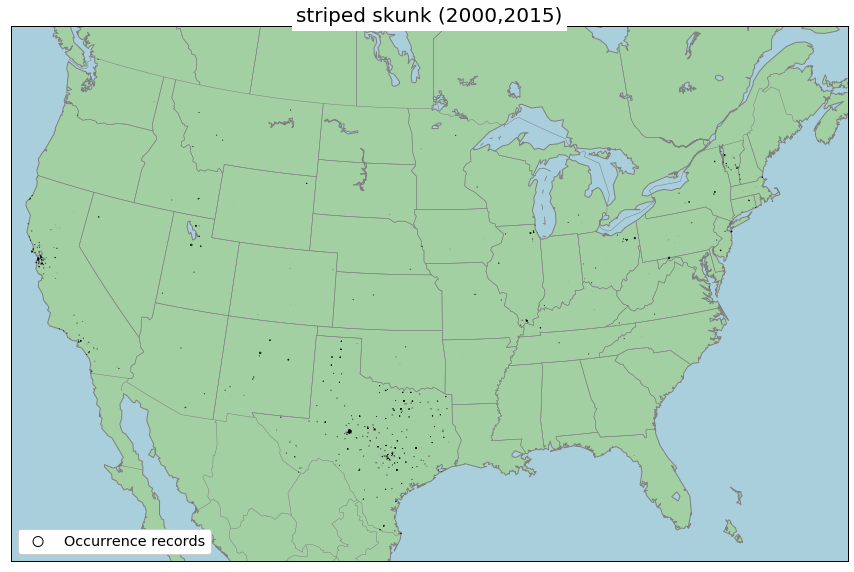

In [18]:
shp1 = {'file': '{0}{1}_polygons'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
map_these=[shp1]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

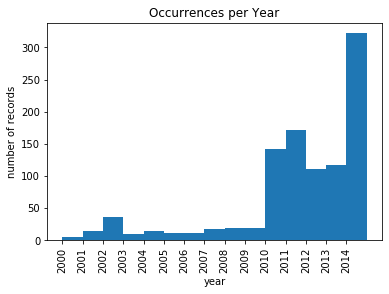

In [19]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

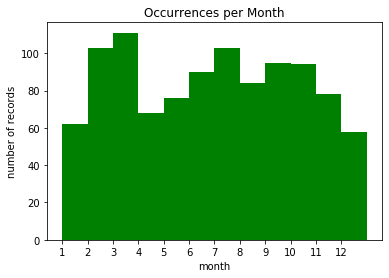

In [20]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

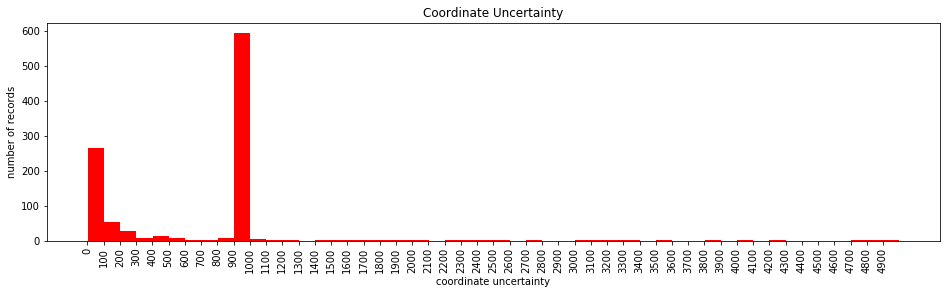

In [21]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty - Zoomed In')

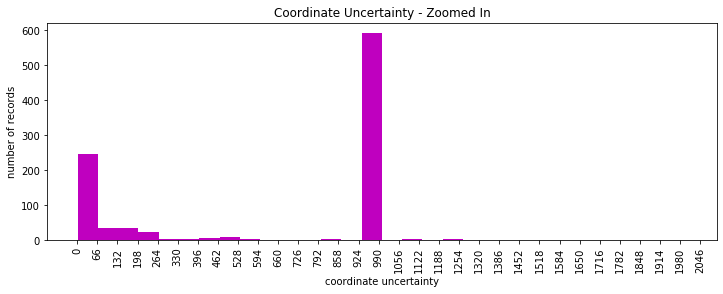

In [22]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty - Zoomed In")

### Establishment means reported

In [23]:
establishment = curs_occ.execute("SELECT vals FROM unique_values WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

NATIVE, UNKNOWN


### Identification qualifiers included

In [24]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM unique_values WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

A cf., A, UNKNOWN


### Remarks included

In [25]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Attributes returned for the records in the request (pre-filters)

In [26]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ)#, index_col='index')
fields_summary.index.name = 'Field'
pd.set_option('display.max_rows', 250)
print(fields_summary)

                                  attribute  included(n)  populated(n)
Field                                                                 
0                    acceptedScientificName         1141          1141
1                          acceptedTaxonKey         1141          1141
2                              accessRights           72            72
3                       associatedSequences            2             2
4                             basisOfRecord         1141          1141
5                     bibliographicCitation            5             5
6                             catalogNumber         1141          1141
7                                     class         1141          1141
8                                  classKey         1141          1141
9                            collectionCode         1141          1141
10                             collectionID           64            64
11                                continent          501           501
12    

### Runtime

In [27]:
t2 = datetime.now()
print(t2 - t1)

0:00:51.763018
